# Activity 2: Building a Network

## A quick note
I would again encourage you to run cells one by one to avoid getting sidetracked.
For this activity, you will also need to download <a href= "https://cytoscape.org/index.html" >Cytoscape</a> to build our model. 

## Introduction

Now that we’ve cited when, where, and what crimes occur, it’s time to determine why. By identifying some of the causes of crimes, officials can make efforts to prevent and predict future criminal activity. According to the <a href= "https://ucr.fbi.gov/hate-crime/2011/resources/variables-affecting-crime#:~:text=The%20transience%20of%20the%20population,and%20comprehending%20the%20crime%20issue." >FBI</a>, the variables affecting crime are as follows:
- Population density 
- Degree of urbanization
- Youth concentration of population
- Family conditions
- Median income
- Poverty level
- Employment
- Education
- Recreational characteristics
- General health

With this information, we'll use data of the Seattle area to answer the following question:
Do all these variables directly correlate with crime rates in Seattle? Do some correlate more than others? If so, why?

To do this, we'll create a network that can visualize the relationship between each of these factors and an area’s crime rate. We'll do this through combining them into a dataset along with an area's crime rate, then selecting certain variables that align to those above. Using the correlations between these variables, we'll draw and analyze a model using Cytoscape.


### Editing Datasets and Choosing Columns
Run the cell below to import the libraries and datasets we'll use in this activity.

In [4]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import networkx as nx

#Edit crime columns
crime = pd.read_csv("updated_crime.csv")
crime = crime.replace("Destruction/Damage/Vandalism of Property", "Destruction/Damage of Property")
crime["GEOID10"] = crime["GEOID10"].map(lambda x: str(x)[:-4]).astype(int)

#Edit equity columns
equity = pd.read_csv("equity.csv")
equity = equity[equity['GEOID10'].isin(crime["GEOID10"].to_list())]

#Use neighborhood table to convert census data
neighborhood = pd.read_csv("neighborhooddata.csv")
new_neighborhood = neighborhood.copy()
new_neighborhood.set_index("CRA_NAME", inplace = True)
new_dict = new_neighborhood.to_dict()["GEOID10"]


census = pd.read_csv("census.csv")
census.replace({"Community Reporting Area Names":new_dict}, inplace = True)
census.rename(columns = {"Community Reporting Area Names": "GEOID10"}, inplace = True)
census["GEOID10"] = census["GEOID10"].map(lambda x: str(x)[:-4]).astype(int)

#Create table with all GEOIDs and the number of crimes in each
get_geo = pd.DataFrame(crime["GEOID10"].value_counts())
get_geo.reset_index(inplace=True)
get_geo.columns=['GEOID10','Count']

#Merge GEOIDs with census and equity data
neighborhood_data = get_geo.merge(census)
neighborhood_data = neighborhood_data.merge(equity)
neighborhood_data["Total Population"] = neighborhood_data["Total Population"].str.replace(',', '').astype(float)
neighborhood_data["Crime Rate"] =((neighborhood_data["Count"]/neighborhood_data["Total Population"])*100000).astype(float)

pd.set_option('display.max_columns', None)
neighborhood_data.head(3)

,GEOID10,Count,CRA_ID,Neighborhood ID,Neighborhood Names,Neighborhood District Name,Area Acres,Area Square Miles,Display Name,Total Population,Median Age (years),Total Households,Average Household Size,Total Housing Units,Occupied Housing Units,Percent Occupied Housing Units,Vacant Housing Units,Percent Value Housing Units,Owner-occupied housing units,High School graduate,Bachelor degree,Percent High school graduate or higher,Percent Bachelor degree or higher,Population 5 years and over,Speak English less than very well,Percent Speak English less than very well,Median household income(dollars),Percentage of all people whose income in the past 12 months is below poverty,Percentage of all families whose income in the past 12 months is below poverty,Total population for whom poverty status is determined,Population 200% below poverty,Percent of Population 200% below poverty,Person of Color,Population under 18,Speak language other than English,Percent of Population that speaks language other than English,Percent of Population under 18 years,"Housing Unit Value Less than $50,000","Housing Unit Value $50,000 to $99,999","Housing Unit Value $100,000 to $149,999","Housing Unit Value $150,000 to $199,999","Housing Unit Value $200,000 to $299,999","Housing Unit Value $300,000 to $499,999","Housing Unit Value $500,000 to $999,999","Housing Unit Value $1,000,000 or more",Median owner-occupied housing unit value(dollars),Median gross rent (dollars),Civilian labor force,Civilian labor force employed,Civilian labor force unemployed,Not in labor force,"Household income less than $10,000","Household income $10,000 to $14,999","Household income $15,000 to $24,999","Household income $25,000 to $34,999","Household income $35,000 to $49,999","Household income $50,000 to $74,999","Household income $75,000 to $99,999","Household income $100,000 to $149,999","Household income $150,000 to $199,999","Household income $200,000 or more",Percent civilian labor force that is unemployed,Profile Name,Population per Gross Acres,Housing Units per Gross Acres,Households per Gross Acres,OBJECTID,NAME10,NAMELSAD10,ACRES_TOTAL,PCT_PEOPLE_OF_COLOR,PTL_PEOPLE_OF_COLOR,PCT_ENGLISH_LESSTHAN_VERY_WELL,PTL_ENGLISH_LESSTHAN_VERY_WELL,PCT_FOREIGN_BORN,PTL_FOREIGN_BORN,PCT_POP_INC_UNDER_200_POVERTY,PTL_POP_INC_UNDER_200_POVERTY,PCT_LESS_BACHELOR_DEGREE,PTL_LESS_BACHELOR_DEGREE,PCT_ADULTNOLEISUREPHYSACTIVITY,PCT_ADULT_WITH_DIABETES,PCT_ADULT_OBESE,PCT_ADULTMENTALHEALTHNOTGOOD,PCT_ADULT_WITH_ASTHMA,PCT_ADULT_WITH_DISABILITIES,PCT_LOW_LIFE_EXPECT_AT_BIRTH,PTL_ADULTNOLEISUREPHYSACTIVITY,PTL_ADULT_DIAGNOSED_DIABETES,PTL_ADULT_OBESE,PTL_ADULTMENTALHEALTHNOTGOOD,PTL_ADULT_WITH_ASTHMA,PTL_ADULT_WITH_DISABILITIES,PTL_LOW_LIFE_EXPECT_AT_BIRTH,COMPOSITE_PERCENTILE,COMPOSITE_QUINTILE,RACE_ELL_ORIGINS_PERCENTILE,RACE_ELL_ORIGINS_QUINTILE,SOCIOECONOMIC_PERCENTILE,SOCIOECONOMIC_QUINTILE,HEALTH_PERCENTILE,HEALTH_QUINTILE,Shape__Area,Shape__Length,Crime Rate
0,53033008100,73487,13.2,13,"Downtown Commercial Core, West Edge, Central B...",Downtown,207,0.3,CRA - Downtown Commercial Core,4872.0,43.3,"2,748",1.48,"3,480","2,748",79.0,732,21.0,635,661,"1,374",91.9,53.5,"4,790",242,5.1,"79,800",24.9,11.2,"4,588","1,532",33.4,"1,842",216,"1,098",22.9,4.4,0.0,0.0,0.0,0.0,47.0,180,244,164,"626,400","1,739","2,797","2,622",175,"1,841",376,118.0,283,174,75,287,273,416,295,451,6.3,ACS 2013-2017 Demographic Profiles Downtown Co...,23.6,16.9,13.3,65,81.0,Census Tract 81,206.340307,0.356599,0.625,0.038445,0.437,0.211133,0.685,0.341554,0.752,0.461631,0.670,0.167,0.090,0.265,0.109,0.090,0.217846,0.7420,0.759,0.819,0.924,0.721,0.639,0.969,0.993,0.775,Second highest,0.610,Second highest,0.730,Second highest,0.903,Highest priority/Most disadvantaged,8.988184e+06,19160.708306,1.508354e+06
1,53033008400,51528,6.2,6,"Capitol Hill, Pike/Pine, Broadway, First Hill",East,427,0.7,CRA - Capitol Hill,23837.0,31.6,"16,044",1.47,"17,090","16,044",93.9,"1,046",6.1,"2,837","1,310","8,360",97.9,67.4,"23,323",564,2.4,"58,476"

Above, we've combined two datasets: the 2010 Community Reporting Areas Profile and the 2010 Racial and Social Equity Composite Index into a single dataset. If you wish to read the sourcepage of the data, the links are below:

<a href= "http://data-seattlecitygis.opendata.arcgis.com/datasets/b7433a239a4945029e95aae402d68385_0" >2010 Community Reporting Areas Profile</a>

<a href= "http://data-seattlecitygis.opendata.arcgis.com/datasets/racial-and-social-equity-composite-index?selectedAttribute=PCT_FOREIGN_BORN" >2010 Racial and Social Equity Composite Index</a>

We've also added a "Crime rate" column (as can be seen above). 

Now, run the cell below to see all the column names in our dataset.

In [5]:
neighborhood_data.columns.to_list()

['GEOID10',
 'Count',
 'CRA_ID',
 'Neighborhood ID',
 'Neighborhood Names',
 'Neighborhood District Name',
 'Area Acres',
 'Area Square Miles',
 'Display Name',
 'Total Population',
 'Median Age (years)',
 'Total Households',
 'Average Household Size',
 'Total Housing Units',
 'Occupied Housing Units',
 'Percent Occupied Housing Units',
 'Vacant Housing Units',
 'Percent Value Housing Units',
 'Owner-occupied housing units',
 'High School graduate',
 'Bachelor degree',
 'Percent High school graduate or higher',
 'Percent Bachelor degree or higher',
 'Population 5 years and over',
 'Speak English less than very well',
 'Percent Speak English less than very well',
 'Median household income(dollars)',
 'Percentage of all people whose income in the past 12 months is below poverty',
 'Percentage of all families whose income in the past 12 months is below poverty',
 'Total population for whom poverty status is determined',
 'Population 200% below poverty',
 'Percent of Population 200% below 

Scroll up and down the list of columns above. Most of these columns will help us determine whether a variable described above (such as education, employment, population density, etc.) affect crime rates.

It's time to pick out the columns that could aid us in building our network.

Here are some of the ways columns were sorted:
- Columns that don't have an effect on crime, such as "Neighborhood ID," "Neighborhood Names," or "Shape__Area" were removed
- "PTL" stands for percentile and "PCT" stands for percent. When searching for correlations between data, it's better to use percentages instead of percentiles, so all percentile columns were removed
- A couple columns that weren't variables of crime were left in, such as "Percent foreign born" or "Percent of population that speaks language other than English." This was to see if there were any correlations to crime that hadn't been accounted for in previous research.

In [6]:
#Choose columns
chosen_columns = [
 'Crime Rate',
 'Median Age (years)',
 'Average Household Size',
 'Percent Occupied Housing Units',
 'Percent Value Housing Units',
 'Percent High school graduate or higher',
 'Percent Bachelor degree or higher',
 'Percent Speak English less than very well',
 'Median household income(dollars)',
 'Percentage of all people whose income in the past 12 months is below poverty',
 'Percent of Population that speaks language other than English',
 'Percent of Population under 18 years',
 'Median gross rent (dollars)',
 'Percent civilian labor force that is unemployed',
 'Population per Gross Acres',
 'Housing Units per Gross Acres',
 'Households per Gross Acres',
 'PCT_POP_INC_UNDER_200_POVERTY',
 'PCT_LESS_BACHELOR_DEGREE',
 'PCT_ADULTNOLEISUREPHYSACTIVITY',
 'PCT_ADULTMENTALHEALTHNOTGOOD',
 'PCT_ADULT_WITH_DISABILITIES',
 'PCT_LOW_LIFE_EXPECT_AT_BIRTH',
 'SOCIOECONOMIC_QUINTILE',
 'HEALTH_QUINTILE']

#Set one-hot encoder values and apply to neighborhood_data
replace_socio = {"Lowest":0, "Second lowest": 1, "Middle": 2, "Second highest":3, 
                 "Highest priority/Most disadvantaged":4}
neighborhood_data = neighborhood_data.replace({"HEALTH_QUINTILE":replace_socio})
neighborhood_data = neighborhood_data.replace({"SOCIOECONOMIC_QUINTILE":replace_socio})
neighborhood_data = neighborhood_data.replace({"COMPOSITE_QUINTILE":replace_socio})


neighborhood_data= neighborhood_data[chosen_columns]
neighborhood_data.head(3)

,Crime Rate,Median Age (years),Average Household Size,Percent Occupied Housing Units,Percent Value Housing Units,Percent High school graduate or higher,Percent Bachelor degree or higher,Percent Speak English less than very well,Median household income(dollars),Percentage of all people whose income in the past 12 months is below poverty,Percent of Population that speaks language other than English,Percent of Population under 18 years,Median gross rent (dollars),Percent civilian labor force that is unemployed,Population per Gross Acres,Housing Units per Gross Acres,Households per Gross Acres,PCT_POP_INC_UNDER_200_POVERTY,PCT_LESS_BACHELOR_DEGREE,PCT_ADULTNOLEISUREPHYSACTIVITY,PCT_ADULTMENTALHEALTHNOTGOOD,PCT_ADULT_WITH_DISABILITIES,PCT_LOW_LIFE_EXPECT_AT_BIRTH,SOCIOECONOMIC_QUINTILE,HEALTH_QUINTILE
0,1.508354e+06,43.3,1.48,79.0,21.0,91.9,53.5,5.1,"79,800",24.9,22.9,4.4,"1,739",6.3,23.6,16.9,13.3,0.341554,0.461631,0.167,0.109,0.217846,0.7420,3,4
1,2.161681e+05,31.6,1.47,93.9,6.1,97.9,67.4,2.4,"58,476",14.0,14.3,4.2,"1,336",2.4,55.9,40.1,37.6,0.287987,0.360307,0.123,0.093,0.105517,0.8529,2,1
2,3.077618e+05,35.4,1.99,97.7,2.3,94.3,54.7,10.6,"72,493",15.3,22.5,15.1,"1,527",7.3,13.6,6.9,6.7,0.417321,0.531968,0.172,0.113,0.152949,0.8333,4,3


Above is our dataset after removing unwanted columns. Here are the columns that were kept:
- Crime Rate
- Median Age (years)
- Average Household Size
- Percent Occupied Housing Units
- Percent Value Housing Units
- Percent High school graduate or higher
- Percent Bachelor degree or higher
- Percent Speak English less than very well
- Median household income(dollars)
- Percentage of all people whose income in the past 12 months is below poverty
- Percent of Population that speaks language other than English
- Percent of Population under 18 years
- Median gross rent (dollars)
- Percent civilian labor force that is unemployed
- Population per Gross Acres
- Housing Units per Gross Acres
- Households per Gross Acres
- PCT_POP_INC_UNDER_200_POVERTY - Percent of the population whose income is under that of 200% poverty
- PCT_LESS_BACHELOR_DEGREE - Percent of the population whose educational attainment is less than a bachelor's degree
- PCT_ADULTNOLEISUREPHYSACTIVITY - Percent of the population with little to no leisure or physical activity
- PCT_ADULTMENTALHEALTHNOTGOOD -  Percent of the population with poor mental health
- PCT_ADULT_WITH_DISABILITIES - Percent of the population with disabilities
- PCT_LOW_LIFE_EXPECT_AT_BIRTH - Percent of the population with a low life expectancy at birth
- SOCIOECONOMIC_QUINTILE - Ranked from 0-4 depending on education and income
- HEALTH_QUINTILE - ranked from 0-4 depending on overall health


As you can see, every column contains numeric values to scale the level of education, employment, population density, health, etc. of an area. Using the crime rate of an area and our previously defined variables of crime, we can use these numerical values to find the correlations between each column below. 

### Finding Correlations

The table below gives an R value, also known as a correlation coefficient, that represents the strength and direction of a linear relationship between two variables in a scatterplot. Correlation coefficients range from -1 to 1, and are interpreted as so:

- If the absolute value of an R value is below 0.4, it indicates a low correlation between two variables. In the image below, the scatterplot with an R value of 0.3 has points farther from the line of best fit.
- If the absolute value of an R value is above 0.4, it indicates a high correlation between two variables. In the image below, the scatterplot with an R value of 0.7 has points closer the line of best fit. 


<img src = "pearson.png" width = "500" height = "1000">


- A positive correlation (above 0) means that the two variables are directly related- if one variable increases, so will the other, and if one variable decreases, so will the other
- A negative correlation (below 0) means that the two variables are inversely related- if one variable increases, the other decreases, and if one variable decreases, the other increases.

<img src = "pearson-2-small.png" width = "500" height = "1000">

The cell below will compare each column in our dataset so we can visualize not only the relationship between crime rate and other variables, but the relationships between individual variables too.

In [7]:
#Convert object columns
neighborhood_data['Median gross rent (dollars)'] = neighborhood_data['Median gross rent (dollars)'].str.replace(',', '').astype(int)
neighborhood_data['Median household income(dollars)'] = neighborhood_data['Median household income(dollars)'].str.replace(',', '').astype(int)

#Find correlations between each column
corr = neighborhood_data.corr(method = 'spearman')
corr

,Crime Rate,Median Age (years),Average Household Size,Percent Occupied Housing Units,Percent Value Housing Units,Percent High school graduate or higher,Percent Bachelor degree or higher,Percent Speak English less than very well,Median household income(dollars),Percentage of all people whose income in the past 12 months is below poverty,Percent of Population that speaks language other than English,Percent of Population under 18 years,Median gross rent (dollars),Percent civilian labor force that is unemployed,Population per Gross Acres,Housing Units per Gross Acres,Households per Gross Acres,PCT_POP_INC_UNDER_200_POVERTY,PCT_LESS_BACHELOR_DEGREE,PCT_ADULTNOLEISUREPHYSACTIVITY,PCT_ADULTMENTALHEALTHNOTGOOD,PCT_ADULT_WITH_DISABILITIES,PCT_LOW_LIFE_EXPECT_AT_BIRTH,SOCIOECONOMIC_QUINTILE,HEALTH_QUINTILE
Crime Rate,1.000000,-0.169745,-0.562636,-0.235419,0.246392,-0.121323,-0.086147,0.035854,-0.332810,0.300941,0.106590,-0.508073,-0.088770,0.201154,0.137268,0.148216,0.151868,0.431579,0.158704,0.186706,0.327695,0.352632,-0.158004,0.286900,0.185649
Median Age (years),-0.169745,1.000000,0.052693,0.093160,-0.104314,-0.191614,-0.213657,-0.048820,0.283581,-0.314015,-0.191375,0.266805,-0.092115,-0.193166,-0.493470,-0.407563,-0.414266,-0.321777,0.141910,0.154820,-0.246568,0.428159,0.082954,-0.035890,0.162775
Average Household Size,-0.562636,0.052693,1.000000,0.335308,-0.342500,-0.344627,-0.255088,0.461001,-0.014831,0.150696,0.379499,0.867166,-0.249241,0.205640,-0.419864,-0.543894,-0.541593,-0.057499,0.133624,0.215747,0.003495,-0.216126,0.032446,0.017817,0.128048
Percent Occupied Housing Units,-0.235419,0.093160,0.335308,1.000000,-0.998835,0.088445,0.078536,-0.011449,0.278366,-0.329975,-0.177266,0.399413,0.137765,-0.270053,-0.260722,-0.273561,-0.241517,-0.342953,-0.118975,-0.181768,-0.310499,-0.264480,0.030277,-0.164646,-0.169358
Percent Value Housing Units,0.246392,-0.104314,-0.342500,-0.998835,1.000000,-0.087547,-0.076319,0.011350,-0.286510,0.329772,0.178812,-0.410817,-0.137330,0.277944,0.267599,0.282567,0.250570,0.344929,0.119398,0.178300,0.312928,0.265229,-0.035244,0.167780,0.166276
Percent High school graduate or higher,-0.121323,-0.191614,-0.344627,0.088445,-0.087547,1.000000,0.905905,-0.813843,0.693083,-0.625209,-0.766192,-0.323964,0.718149,-0.573107,0.214322,0.305105,0.294231,-0.522761,-0.803484,-0.854777,-0.620585,-0.521140,0.380039,-0.693814,-0.766527
Percent Bachelor degree or higher,-0.086147,-0.213657,-0.255088,0.078536,-0.076319,0.905905,1.000000,-0.730500,0.767412,-0.561377,-0.666211,-0.280855,0.713657,-0.549689,0.267996,0.328473,0.316541,-0.499873,-0.915119,-0.853114,-0.662783,-0.567293,0.486080,-0.759157,-0.801374
Percent Speak English less than very well,0.035854,-0.048820,0.461001,-0.011449,0.011350,-0.813843,-0.730500,1.000000,-0.666768,0.749962,0.926108,0.336609,-0.535146,0.693816,-0.123075,-0.250228,-0.237830,0.543171,0.628349,0.741489,0.575946,0.300907,-0.157602,0.591071,0.580523
Median household income(dollars),-0.332810,0.283581,-0.014831,0.278366,-0.286510,0.693083,0.767412,-0.666768,1.000000,-0.735031,-0.693881,0.105234,0.695921,-0.700633,-0.072788,0.022679,0.014175,-0.751253,-0.762488,-0.734154,-0.793851,-0.438990,0.354236,-0.765088,-0.621174
Percentage of all people whose income in the past 12 months is below poverty,0.300941,-0.314015,0.150696,-0.329975,0.329772,-0.625209,-0.561377,0.749962,-0.735031,1.000000,0.810083,-0.043989,-0.452751,0.699200,0.245052,0.093252,0.101205,0.798158,0.516247,0.692269,0.698410,0.338901,-0.228678,0.635335,0.581545


Run the following cell to load the first couple rows of the table.

In [8]:
corr.head(3)

,Crime Rate,Median Age (years),Average Household Size,Percent Occupied Housing Units,Percent Value Housing Units,Percent High school graduate or higher,Percent Bachelor degree or higher,Percent Speak English less than very well,Median household income(dollars),Percentage of all people whose income in the past 12 months is below poverty,Percent of Population that speaks language other than English,Percent of Population under 18 years,Median gross rent (dollars),Percent civilian labor force that is unemployed,Population per Gross Acres,Housing Units per Gross Acres,Households per Gross Acres,PCT_POP_INC_UNDER_200_POVERTY,PCT_LESS_BACHELOR_DEGREE,PCT_ADULTNOLEISUREPHYSACTIVITY,PCT_ADULTMENTALHEALTHNOTGOOD,PCT_ADULT_WITH_DISABILITIES,PCT_LOW_LIFE_EXPECT_AT_BIRTH,SOCIOECONOMIC_QUINTILE,HEALTH_QUINTILE
Crime Rate,1.000000,-0.169745,-0.562636,-0.235419,0.246392,-0.121323,-0.086147,0.035854,-0.332810,0.300941,0.106590,-0.508073,-0.088770,0.201154,0.137268,0.148216,0.151868,0.431579,0.158704,0.186706,0.327695,0.352632,-0.158004,0.286900,0.185649
Median Age (years),-0.169745,1.000000,0.052693,0.093160,-0.104314,-0.191614,-0.213657,-0.048820,0.283581,-0.314015,-0.191375,0.266805,-0.092115,-0.193166,-0.493470,-0.407563,-0.414266,-0.321777,0.141910,0.154820,-0.246568,0.428159,0.082954,-0.035890,0.162775
Average Household Size,-0.562636,0.052693,1.000000,0.335308,-0.342500,-0.344627,-0.255088,0.461001,-0.014831,0.150696,0.379499,0.867166,-0.249241,0.205640,-0.419864,-0.543894,-0.541593,-0.057499,0.133624,0.215747,0.003495,-0.216126,0.032446,0.017817,0.128048


We can see that crime rate has a perfect correlation coefficient of 1.0 with crime rate. This is obvious, since the two columns are exactly the same.

For the following questions, find:
    
- The R value between the two variables
- The type of correlation it indicates


<blockquote>
<h4>Median age and crime rate</h4>
<details><summary>Solution:</summary>
Crime rate and median age have an R value of -0.16, a low negative correlation. This indicates that they are hardly related.
    </details>

<h4>Average Household Size and Crime Rate</h4>
<details><summary>Solution:</summary>
Crime rate and average household size have an R value of -0.56, a high negative correlation. This indicates that crime rate and average household size are related- for every positive increase in the crime rate, there is a decrease in the average household size. Therefore, an area with a smaller average household size would be more likely to have a high crime rate.
     </details>
    
<h4>Average Household Size and Percent of Population under 18 years</h4>
<details><summary>Solution:</summary>
Average household size and the percent of the population under 18 years have an R value of 0.87, a high positive correlation. This indicates that these two variables are related- for every increase in the average household size, there is an increase in the percent of the population under 18 years of age. An area with a high average household size would most likely have a high percent of the population under 18 years of age.
     </details>
    
<h4>Median age and Percent Occupied Housing Units</h4>
<details><summary>Solution:</summary>
Median age and percent occupied housing units have an R value of 0.093, a low positive correlation. This low correlation coefficient indicates that the two are hardly related.
  </details>
   
    
</blockquote>

All the relationships that were statistically significant (absolute value of r is greater than 0.4) are in the table below.

In [9]:
#Find links between columns depending on correlation
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links_filtered=links.loc[(abs(links['value']) > 0.4) & (links['var1'] != links['var2'])]
links_filtered

,var1,var2,value
2,Crime Rate,Average Household Size,-0.562636
11,Crime Rate,Percent of Population under 18 years,-0.508073
17,Crime Rate,PCT_POP_INC_UNDER_200_POVERTY,0.431579
39,Median Age (years),Population per Gross Acres,-0.493470
40,Median Age (years),Housing Units per Gross Acres,-0.407563
...,...,...,...
619,HEALTH_QUINTILE,PCT_ADULTNOLEISUREPHYSACTIVITY,0.899676
620,HEALTH_QUINTILE,PCT_ADULTMENTALHEALTHNOTGOOD,0.784441
621,HEALTH_QUINTILE,PCT_ADULT_WITH_DISABILITIES,0.763201
622,HEALTH_QUINTILE,PCT_LOW_LIFE_EXPECT_AT_BIRTH,-0.700180


We will use this table to create a map in Cytoscape. The cell below will download a CSV file of the table above, but it may appear in the "files" menu in Jupyter Notebook. If so, open it, go to "file," and click "download."

In [10]:
#Get table of links
relationships = links_filtered.drop(["value"],axis = 1)
relationships.to_csv("relationships.csv")

#### If you are unable to use Cytoscape or download the necessary table, scroll to the "Networkx" section of this page.

### Using Cytoscape to build a network
This part of the activity requires <a href= "https://cytoscape.org/index.html" >Cytoscape</a> to build a network of the relations between our columns.


1. Open Cytoscape, then click "File," "Import," then "Network from File." Select the table you just downloaded, "relationships.csv". 
2. On the column labeled "var1," click and select the green circle. On the column labeled "var2," click and select the red target. Your screen should look a bit like this:


<img src = "Cytoscape.png" width = "500" height = "1000">

3. Hit "ok," then the "style" button on the left side of the page.
4. Under the dropdown menu at the top left, select the style "sample1." This will make your model a little easier to view.
<blockquote>
    <h3>Model Investigation:</h3>

    Find the "Crime Rate" node. What other nodes are connected to it? What does this mean? 
    
    Do these nodes share correlations with others?

    <br>

    <details><summary>Solution:</summary>
    The "Crime Rate" node is connected to the "Average Household Size," "Percent of Population under 18 years," and "PCT_POP_INC_UNDER_200_POVERTY" nodes. This means that crime rate has a high correlation with these factors. However, several of these nodes are also correlated to others as well. "Average Household Size" and "Percent of Population under 18 years" are correlated to other variables that involve population density and degree of urbanization, such as "Population per Gross Acre" and "Housing Units per Gross Acre. "PCT_POP_INC_UNDER_200_POVERTY," which stands for "percent of the population whose income is 200% under that of poverty level," is correlated with a wide range of variables that involve mental health, physical health, income, education, and employment.
      </details> 
</blockquote>
What's the relation between Crime Rate and these nodes? Run the following cell to find out.

In [11]:
links_filtered.head(3)

,var1,var2,value
2,Crime Rate,Average Household Size,-0.562636
11,Crime Rate,Percent of Population under 18 years,-0.508073
17,Crime Rate,PCT_POP_INC_UNDER_200_POVERTY,0.431579


### Model Investigation pt.  2
- <h4> Crime Rate and Average Household Size: </h4> Crime rate and average household size have an R value of -0.56, meaning that for every decrease in average household size, there is an increase in crime rate (and vice versa). Areas with a high average household size generally have more than 1 or 2 people living in them, which indicates that a higher density of unified families live there. Living in a family setting generally discourages adults or youth from committing crimes, which is why the crime rate is generally low for these areas.


- <h4> Crime Rate and Percent of Population under 18 years: </h4> Crime rate and percent of the population under 18 years of age have an R value of -0.5, meaning that for every increase in the percent of population under 18 years of age, there is a decrease in crime rate. This makes sense for the same reason as above- an area with a high youth concentration would tend to be more family-centered, which could discourage crime.

- <h4> Crime Rate and Percent of Population under 200 percent of poverty: </h4> Crime rate and percent of population whose income is under 200 percent of poverty have an R value of 0.43, meaning that for every increase in the percent under 200 percent of poverty, there is an increase in crime rate. This makes sense, since areas with a high poverty concentration would tend to have a high crime rate.
    
    

### Key Takeaways
Let's answer the question we asked at the beginning of this activity:

Do all the following variables directly correlate with crime rates in Seattle? Do some correlate more than others? If so, why?
- Population density 
- Degree of urbanization
- Youth concentration of population
- Family conditions
- Median income
- Poverty level
- Employment
- Education
- Recreational characteristics
- General health

<details><summary>Solution:</summary>
    Not all of the variables above were directly correlated with crime in Seattle, but those that did were closely associated with population density, youth concentration, family conditions, and poverty level. However, this is not to say that the other variables did not affect crime rates in any way. Factors like poverty level are correlated to general health, employment, education, and income, which are correlated to recreational characteristics and urbanization. Though we’ve concluded that some variables are more closely related to crime than others, it’s important to remember that there are a lot of different factors that all share complex relations to each other. These relations all act together to alter an area’s crime rate.

</details> 

Now that we know a little about the relationships between variables affecting crime, can we use them to predict crime rates in different areas? Proceed to "Activity 3: Applying Machine Learning" to find out!

### Using Networkx (Only nessesary if you skipped "Using Cytoscape" section)

If you are unable to download the table or Cytoscape, select the three quotation marks (""") at the beginning and end of the following code block, then run it. It will also produce a network, but it'll just be harder to read than the Cytoscape version. Once you have completed this, continue to the "Model Investigation" and "Model Investigation pt.2" sections.

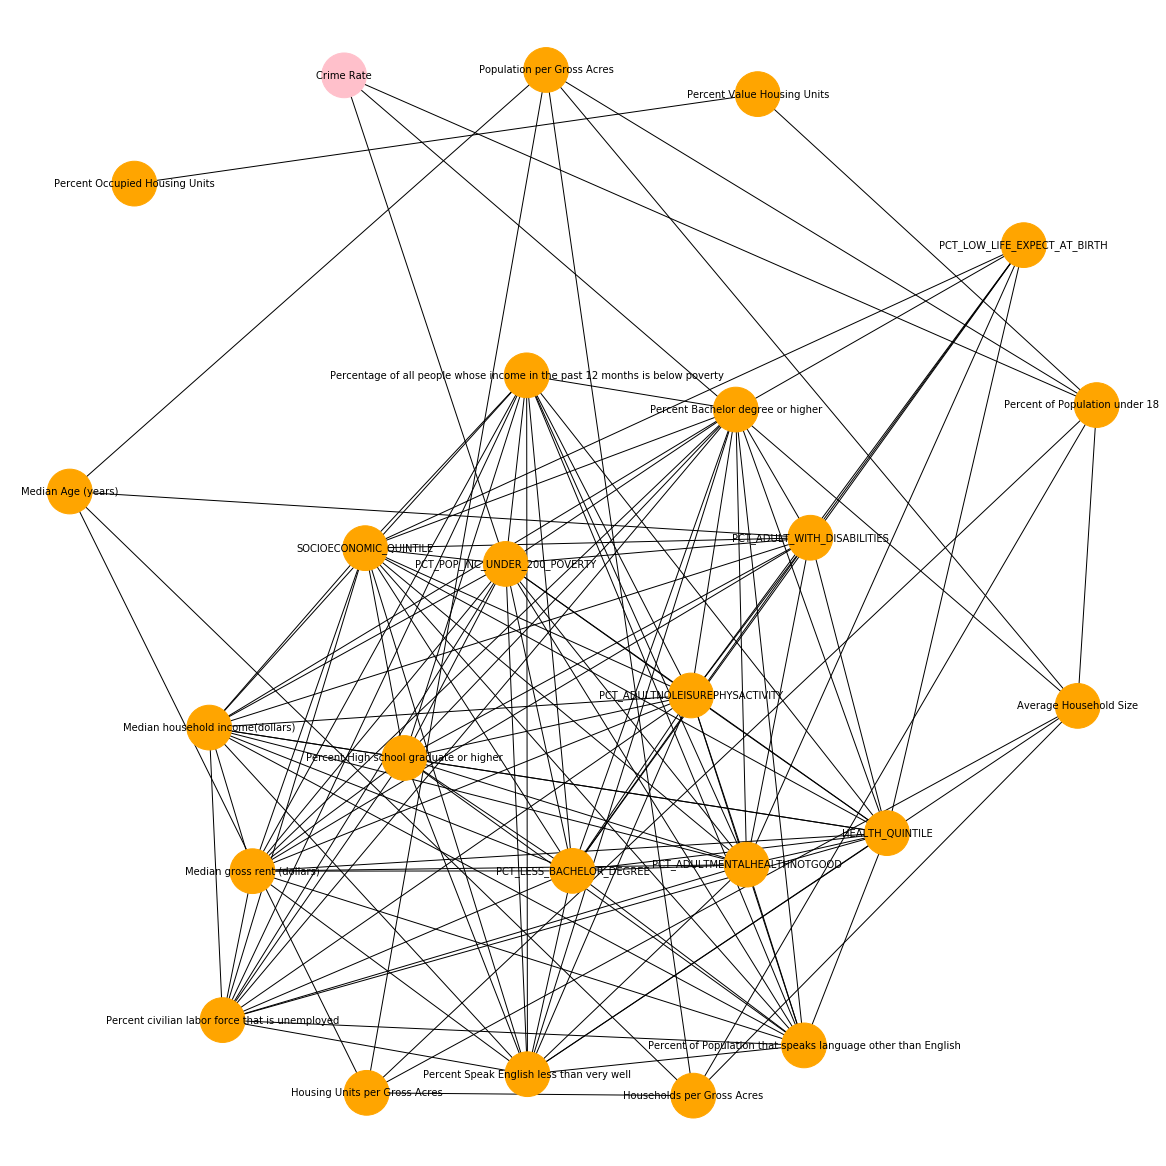

In [12]:
#Get network
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
#Draw Network
plt.figure(figsize=(16,16))
color_map = []

for node in G:
    if node == "Crime Rate":
        color_map.append('pink')
    else:
        color_map.append('orange')

pos = nx.spring_layout(G, k=10*1/np.sqrt(len(G.nodes())), iterations=40)
nx.draw(G,with_labels=True,node_color=color_map, pos=pos, node_size=2000, 
        edge_color='black', font_size=10)